<a href="https://colab.research.google.com/github/khadeom/App/blob/new/Copy_of_Copy_of_02_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we need to install CLIP and then make sure that we have torch 1.7.1 with CUDA support.

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-rhsna5j3
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-rhsna5j3
     |████████████████████████████████| 71kB 2.9MB/s 
     |████████████████████████████████| 776.8MB 19kB/s 
     |████████████████████████████████| 12.8MB 278kB/s 
  Created wheel for clip: filename=clip-1.0-cp37-none-any.whl size=1368722 sha256=9304b21f73d86fc3b9d0c60a9dc3d61548236fc8b4c384c513bf39b7eec174d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-f2ajv0i8/wheels/79/51/d7/69f91d37121befe21d9c52332e04f592e17d1cabc7319b3e09
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41935 sha256=b5704c544df9a6c25f1fcc35d3c5121b807e8e1b4bdaa9ccbf8dbc7f4de24d83
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built clip ftfy
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Fo

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 24kB/s 
     |████████████████████████████████| 12.8MB 32.5MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1+cu101 which is incompatible.
  Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
  Found existing installation: torchvision 0.8.2
    Uninstalling torchvision-0.8.2:
      Successfully uninstalled torchvision-0.8.2


We can now load the pretrained public CLIP model.

In [ ]:
import clip
import torch

# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

## Download the Precomputed Data

In this section the precomputed feature vectors for all photos are downloaded.

In order to compare the photos from the Unsplash dataset to a text query, we need to compute the feature vector of each photo using CLIP. This is a time consuming task, so you can use the feature vectors that I precomputed and uploaded to Google Drive (with the permission from Unsplash). If you want to compute the features yourself, see [here](https://github.com/haltakov/natural-language-image-search#on-your-machine).

We need to download two files:
* `photo_ids.csv` - a list of the photo IDs for all images in the dataset. The photo ID can be used to get the actual photo from Unsplash.
* `features.npy` - a matrix containing the precomputed 512 element feature vector for each photo in the dataset.

The files are available on [Google Drive](https://drive.google.com/drive/folders/1WQmedVCDIQKA2R33dkS1f980YsJXRZ-q?usp=sharing).

In [ ]:
from pathlib import Path

# Create a folder for the precomputed features
!mkdir unsplash-dataset

# Download the photo IDs and the feature vectors
!gdown --id 1FdmDEzBQCf3OxqY9SbU-jLfH_yZ6UPSj -O unsplash-dataset/photo_ids.csv
!gdown --id 1L7ulhn4VeN-2aOM-fYmljza_TQok-j9F -O unsplash-dataset/features.npy

# Download from alternative source, if the download doesn't work for some reason (for example download quota limit exceeded)
if not Path('unsplash-dataset/photo_ids.csv').exists():
  !wget https://transfer.army/api/download/9Z976uW4x_Q/MwBsKNX4 -O unsplash-dataset/photo_ids.csv

if not Path('unsplash-dataset/features.npy').exists():
  !wget https://transfer.army/api/download/3bNN8ysWN4U/T7815nW8 -O unsplash-dataset/features.npy
  

Permission denied: https://drive.google.com/uc?id=1FdmDEzBQCf3OxqY9SbU-jLfH_yZ6UPSj
Maybe you need to change permission over 'Anyone with the link'?
Permission denied: https://drive.google.com/uc?id=1L7ulhn4VeN-2aOM-fYmljza_TQok-j9F
Maybe you need to change permission over 'Anyone with the link'?
--2021-06-13 15:10:51--  https://transfer.army/api/download/9Z976uW4x_Q/MwBsKNX4
Resolving transfer.army (transfer.army)... 18.185.236.87
Connecting to transfer.army (transfer.army)|18.185.236.87|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-06-13 15:10:51 ERROR 404: Not Found.

--2021-06-13 15:10:52--  https://transfer.army/api/download/3bNN8ysWN4U/T7815nW8
Resolving transfer.army (transfer.army)... 18.185.236.87
Connecting to transfer.army (transfer.army)|18.185.236.87|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-06-13 15:10:52 ERROR 404: Not Found.



After the files are downloaded we need to load them using `pandas` and `numpy`.

In [ ]:
import pandas as pd
import numpy as np

# Load the photo IDs
photo_ids = pd.read_csv("unsplash-dataset/photo_ids.csv")
photo_ids = list(photo_ids['photo_id'])

# Load the features vectors
photo_features = np.load("unsplash-dataset/features.npy")

# Convert features to Tensors: Float32 on CPU and Float16 on GPU
if device == "cpu":
  photo_features = torch.from_numpy(photo_features).float().to(device)
else:
  photo_features = torch.from_numpy(photo_features).to(device)

# Print some statistics
print(f"Photos loaded: {len(photo_ids)}")

EmptyDataError: ignored

## Define Functions

Some important functions for processing the data are defined here.



The `encode_search_query` function takes a text description and encodes it into a feature vector using the CLIP model.

In [ ]:
def encode_search_query(search_query):
  with torch.no_grad():
    # Encode and normalize the search query using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the feature vector
  return text_encoded

The `find_best_matches` function compares the text feature vector to the feature vectors of all images and finds the best matches. The function returns the IDs of the best matching photos.

In [ ]:
def find_best_matches(text_features, photo_features, photo_ids, results_count=3):
  # Compute the similarity between the search query and each photo using the Cosine similarity
  similarities = (photo_features @ text_features.T).squeeze(1)

  # Sort the photos by their similarity score
  best_photo_idx = (-similarities).argsort()

  # Return the photo IDs of the best matches
  return [photo_ids[i] for i in best_photo_idx[:results_count]]

The `display_photo` function displays a photo from Unsplash given its ID and link to the original photo on Unsplash. 

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML

def display_photo(photo_id):
  # Get the URL of the photo resized to have a width of 320px
  photo_image_url = f"https://unsplash.com/photos/{photo_id}/download?w=320"

  # Display the photo
  display(Image(url=photo_image_url))

  # Display the attribution text
  display(HTML(f'Photo on <a target="_blank" href="https://unsplash.com/photos/{photo_id}">Unsplash</a> '))
  print()

Putting it all together in one function.

In [ ]:
def search_unslash(search_query, photo_features, photo_ids, results_count=3):
  # Encode the search query
  text_features = encode_search_query(search_query)

  # Find the best matches
  best_photo_ids = find_best_matches(text_features, photo_features, photo_ids, results_count)

  # Display the best photos
  for photo_id in best_photo_ids:
    display_photo(photo_id)


In [ ]:
search_query = "Two dogs playing in the snow"

search_unslash(search_query, photo_features, photo_ids, 3)

NameError: ignored

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.1MB/s 
     |████████████████████████████████| 194kB 39.5MB/s 
     |████████████████████████████████| 1.2MB 32.9MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

## The Practice of Deep Learning

### Starting Your Project

### The State of Deep Learning

#### Computer vision

#### Text (natural language processing)

#### Combining text and images

#### Tabular data

#### Recommendation systems

#### Other data types

### The Drivetrain Approach

## Gathering Data

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [ ]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', '1568d1b92fbc9f0892a2f3bc5a1ca01a')

In [ ]:
search_images_bing

<function fastbook.search_images_bing>

In [ ]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

HTTPError: ignored

In [ ]:
pip install bing-image-downloader

In [ ]:
from bing_image_downloader import downloader
downloader.download(query_string, limit=100,  output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=60, verbose=True)

In [ ]:
from bing_image_downloader import downloader
for q in ["grizzly", "black bear", "teddy bear"]: downloader.download(q, limit=20, output_dir='/content/gdrive/MyDrive/1_images', adult_filter_off=True, force_replace=False, timeout=5) 

[%] Downloading Images to /content/gdrive/MyDrive/1_images/grizzly


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://4.bp.blogspot.com/-2_RuGHXGm0Y/UQW3vwH37JI/AAAAAAAAEzc/Mt1seFmFrog/s1600/Grizzly-Bear-.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://1.bp.blogspot.com/-422rK0Kje1E/UQW3yELFQeI/AAAAAAAAEzs/Rcg4Gniz4rU/s1600/Grizzly-Bear-2.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://i.pinimg.com/originals/95/33/ef/9533ef1cd9e5245520263afae033f77f.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://miro.medium.com/max/879/1*cBBVLzODaagrL7V2eNSjSQ.jpeg
[Error]Invalid image, not saving https://miro.medium.com/max/879/1*cBBVLzODaagrL7V2eNSjSQ.jpeg

[!] Issue getting: https://miro.medium.com/max/879/1*cBBVLzODaagrL7V2eNSjSQ.jpeg
[!] Error:: Invalid image, not saving https://miro.medium.com/max/879/1*cBBVLzODaagrL7V2eNSjSQ.jpeg

[%] Downloading Image #4 from https://small-talks.com/wp-content/uploa

In [ ]:
#hide
ims = ['https://i.pinimg.com/originals/31/7a/eb/317aeb7f4c7f4c27b77ceeaa350858b1.jpg']

In [ ]:
cd "root"

[Errno 2] No such file or directory: 'root'
/root


In [ ]:
dest = '/content/bears/grizzly.jpg'
download_url(ims[0], dest)

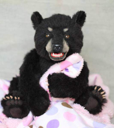

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
bear_types = 'grizzly','black','teddy'
# path = Path('bears')  #give path that does not exists
path=Path('/content/gdrive/MyDrive/1_images/bears')

In [ ]:
if not path.exists():
    path.mkdir()   #make director
    for o in bear_types:
        dest = (path/o)   #this '/' here makes new path for dir ie path/black bears
        print(dest)
        dest.mkdir(exist_ok=True)   #new dir created
        #results = search_images_bing(key, f'{o} bear')
        downloader.download(f'{o} bear', limit=100,  output_dir=dest, adult_filter_off=True, force_replace=False, timeout=60, verbose=True)
        #download_images(dest, urls=results.attrgot('contentUrl'))

/content/gdrive/MyDrive/1_images/bears/grizzly
[%] Downloading Images to /content/gdrive/MyDrive/1_images/bears/grizzly/grizzly bear


[!!]Indexing page: 1

[%] Indexed 100 Images on Page 1.


[%] Downloading Image #1 from https://4.bp.blogspot.com/-2_RuGHXGm0Y/UQW3vwH37JI/AAAAAAAAEzc/Mt1seFmFrog/s1600/Grizzly-Bear-.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://1.bp.blogspot.com/-422rK0Kje1E/UQW3yELFQeI/AAAAAAAAEzs/Rcg4Gniz4rU/s1600/Grizzly-Bear-2.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://elelur.com/data_images/mammals/grizzly-bear/grizzly-bear-05.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://miro.medium.com/max/879/1*cBBVLzODaagrL7V2eNSjSQ.jpeg
[Error]Invalid image, not saving https://miro.medium.com/max/879/1*cBBVLzODaagrL7V2eNSjSQ.jpeg

[!] Issue getting: https://miro.medium.com/max/879/1*cBBVLzODaagrL7V2eNSjSQ.jpeg
[!] Error:: Invalid image, not saving https://miro.medium.com/max/879/1*cBBVLzODaagrL7V2eNSjSQ.jpeg

[%] Downl

In [ ]:
pth="/content/bears"

In [ ]:
type(Path("bears"))

pathlib.PosixPath

In [ ]:
pth=Path("bears")
pth=Path("/content/bears")

In [ ]:
pth/"black bear"

Path('/content/bears/black bear')

In [ ]:
pth.exists()

False

In [ ]:
fns = get_image_files(path)
fns[40:]

(#20) [Path('/content/bears/black bear/Image_6.jpeg'),Path('/content/bears/black bear/Image_3.jpg'),Path('/content/bears/black bear/Image_17.jpg'),Path('/content/bears/black bear/Image_11.jpg'),Path('/content/bears/black bear/Image_18.jpeg'),Path('/content/bears/black bear/Image_8.jpg'),Path('/content/bears/black bear/Image_19.jpg'),Path('/content/bears/black bear/Image_1.jpg'),Path('/content/bears/black bear/Image_10.jpg'),Path('/content/bears/black bear/Image_2.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
failed.map(Path.unlink); #if there is an image which failed to load

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #data , lable
    get_items=get_image_files,  #how to get data
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #test train split
    get_y=parent_label,       #get lables of y (by using folder name)
    item_tfms=Resize(128))    #resize to 128 as we neet it for our model input

In [ ]:
dls = bears.dataloaders(path)   #path to images dataloders-load 64 images to gpu

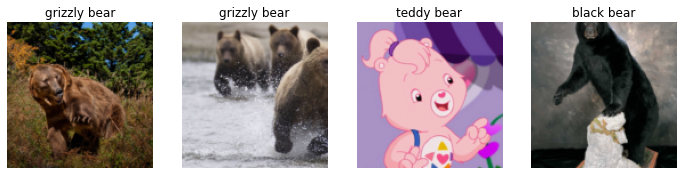

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

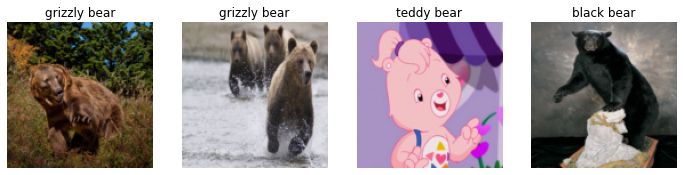

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

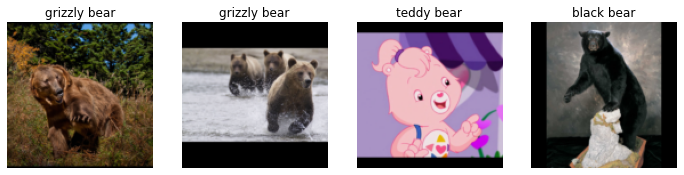

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

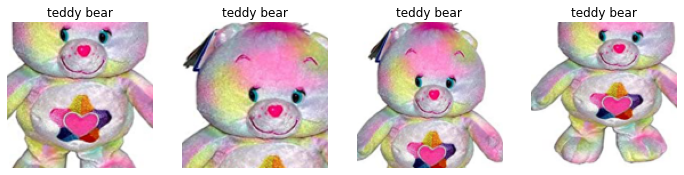

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

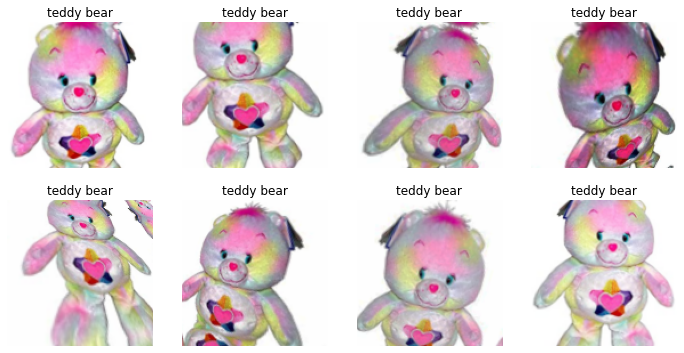

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/grizzly.jpg')

In [ ]:
learn_inf.dls.vocab

### Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [1]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.6MB 5.2MB/s 
     |████████████████████████████████| 552kB 18.3MB/s 
     |████████████████████████████████| 389kB 24.3MB/s 
     |████████████████████████████████| 122kB 24.2MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 430kB 24.6MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
  Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?


### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
1. Where do text models currently have a major deficiency?
1. What are possible negative societal implications of text generation models?
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
1. What kind of tabular data is deep learning particularly good at?
1. What's a key downside of directly using a deep learning model for recommendation systems?
1. What are the steps of the Drivetrain Approach?
1. How do the steps of the Drivetrain Approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.
1. What is `DataLoaders`?
1. What four things do we need to tell fastai to create `DataLoaders`?
1. What does the `splitter` parameter to `DataBlock` do?
1. How do we ensure a random split always gives the same validation set?
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out-of-domain data"?
1. What is "domain shift"?
1. What are the three steps in the deployment process?

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.

In [ ]:
!pip install streamlit


     |████████████████████████████████| 7.8MB 6.4MB/s 
     |████████████████████████████████| 112kB 45.8MB/s 
     |████████████████████████████████| 4.2MB 35.2MB/s 
     |████████████████████████████████| 174kB 45.6MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
     |████████████████████████████████| 122kB 43.3MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
  Created wheel for blinker: filename=blinker-1.4-cp37-none-any.whl size=13476 sha256=5df6196a5abeba4f1e3550b8850b5f0e417f8bba40458a8612a851ed28d9583d
  Stored in directory: /root/.cache/pip/wheels/92/a0/00/8690a57883956a301d91cf4ec999cc0b258b01e3f548f86e89
Successfully built blinker
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.5 which is incompatible.
  Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1


In [ ]:
import streamlit as st
st.write("""Hello World of apps""")

2021-06-18 07:54:25.038 
  command:

    streamlit run /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py [ARGUMENTS]


In [ ]:
 !streamlit run /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py 



  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.125.36.224:8501

[IPKernelApp] ERROR | Unable to initialize signal:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 583, in initialize
    self.init_signal()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 435, in init_signal
    signal.signal(signal.SIGINT, signal.SIG_IGN)
  File "/usr/lib/python3.7/signal.py", line 47, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread
